# Node Embeddings

In [14]:
from ge import DeepWalk

# Data Preparation

In [15]:
# load graph from networkx library
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler


G = nx.karate_club_graph()

labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# convert nodes from int to str format
keys = np.arange(0,34)
values = [str(i) for i in keys]
dic = dict(zip(keys, values))
H = nx.relabel_nodes(G, dic)

# train the model and generate embeddings
model = DeepWalk(H, walk_length=10, num_walks=80, workers=1)
model.train(window_size=5,iter=3)

embeddings = model.get_embeddings()

Learning embedding vectors...
Learning embedding vectors done!


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


# Visualization of embeddings

/Users/tonygong/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


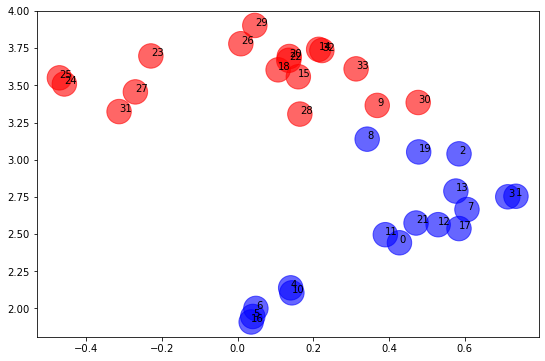

In [39]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# retrieve the labels for each node
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# assigning colours to node labels
color_map = []
for i in labels:
    if i == 0:
        color_map.append('blue')
    else: 
        color_map.append('red')  

# transform the embeddings from 128 dimensions to 2D space
m = TSNE(learning_rate=20, random_state=42)
tsne_features = m.fit_transform(list(embeddings.values()))

# plot the transformed embeddings
plt.figure(figsize=(9,6)) 
plt.scatter(x = tsne_features[:,0], 
            y = tsne_features[:,1],
            c = color_map,
            s =600,
            alpha=0.6)

# adds annotations
for i, label in enumerate(np.arange(0,34)):
    plt.annotate(label, (tsne_features[:,0][i], tsne_features[:,1][i]))

# save the visualization
plt.savefig('tsne.png', bbox_inches='tight',dpi = 1000)

# Data Preparation

In [7]:
import networkx as nx
import numpy as np
import torch
import pandas as pd

# load graph from networkx library
G = nx.karate_club_graph()

# retrieve the labels for each node
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

# create edge index from 
adj = nx.to_scipy_sparse_matrix(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

# prepare the embeddings
nodes = pd.DataFrame(list(H.nodes()))
nodes.columns = ['nodes']
nodes['embeddings'] = nodes['nodes'].map(embeddings)
embeddings = torch.from_numpy(np.stack(nodes.embeddings.values))

# Custom dataset

In [8]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

# custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding 
        data.x = embeddings.type(torch.float32)
        
        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(G.nodes()), 
                                                            pd.Series(labels),
                                                            test_size=0.30, 
                                                            random_state=42)
        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = KarateDataset()
data = dataset[0]

# GCN

In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN model with 2 layers 
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, int(data.num_classes))

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data =  data.to(device)

model = Net().to(device) 

In [40]:
print(data)

Data(edge_index=[2, 156], num_nodes=34, x=[34, 128], y=[34], num_classes=2, train_mask=[34], test_mask=[34])


# Training

In [12]:
torch.manual_seed(42)

optimizer_name = "Adam"
lr = 1e-1
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 200

def train():
  model.train()
  optimizer.zero_grad()
  F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
  optimizer.step()

@torch.no_grad()
def test():
  model.eval()
  logits = model()
  mask1 = data['train_mask']
  pred1 = logits[mask1].max(1)[1]
  acc1 = pred1.eq(data.y[mask1]).sum().item() / mask1.sum().item()
  mask = data['test_mask']
  pred = logits[mask].max(1)[1]
  acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
  return acc1,acc

for epoch in range(1, epochs):
  train()

train_acc,test_acc = test()

print('#' * 70)
print('Train Accuracy: %s' %train_acc )
print('Test Accuracy: %s' % test_acc)
print('#' * 70)

######################################################################
Train Accuracy: 1.0
Test Accuracy: 0.9090909090909091
######################################################################
